In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from PIL import Image, ImageChops
from scipy.signal import  correlate2d
import pywt

(CVXPY) Apr 11 10:54:35 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 11 10:54:35 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# Defining code to test metrics
def mse(image1, image2):
    squared_diff = (image1 - image2) ** 2
    mse = squared_diff.mean()
    return mse
def mad(image1, image2):
  diff = image1 - image2
  return np.mean(abs(diff))

In [3]:
X_full= mpl.pyplot.imread('face.jpeg') #loading image
X_full = X_full.mean(axis=2) #changing it to "grayscale"
X = spimg.zoom(X_full, 1) #downsizing image
height,width = X.shape #getting height and width of image

In [4]:
#Creating custom DCT funcitions for 2D arrays because scipy only works on 1D
def dct2 ( x ) :
  return spfft.dct(spfft.dct( x.T , norm = "ortho" , axis = 0).T , norm = "ortho" , axis = 0 )
def idct2 ( x ) :
  return spfft.idct( spfft.idct( x.T , norm = "ortho" , axis = 0 ).T , norm = "ortho" , axis = 0)
     

In [5]:
Y = dct2(X)
y = Y[:45,:45].flatten()

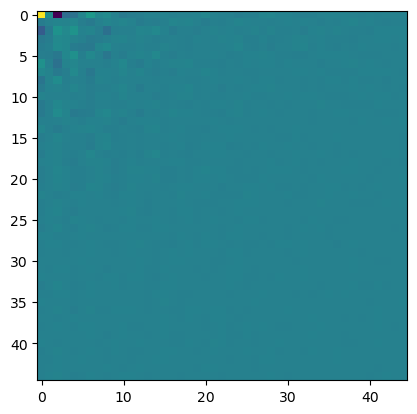

In [6]:
plt.imshow(Y[:45, :45])

In [7]:
A = np.random.randint(0,2,(45**2,45**2)) # gaussian sensing matrix
b = A@y

In [8]:
# Doing optimization
ysparse = cvx.Variable(45**2)
obj = cvx.Minimize(cvx.norm(ysparse, 1))
constraints = [cvx.norm(A@ysparse - b,2) <= 1e-12]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

/Users/Divya/anaconda3/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [9]:
y_corner = ysparse.value
y_corner = y_corner.reshape((45,45))

image = np.zeros((height, width))
image[:45,:45] = y_corner
np.count_nonzero(image)

2025

In [10]:
# Reconstructing
image = idct2(image)

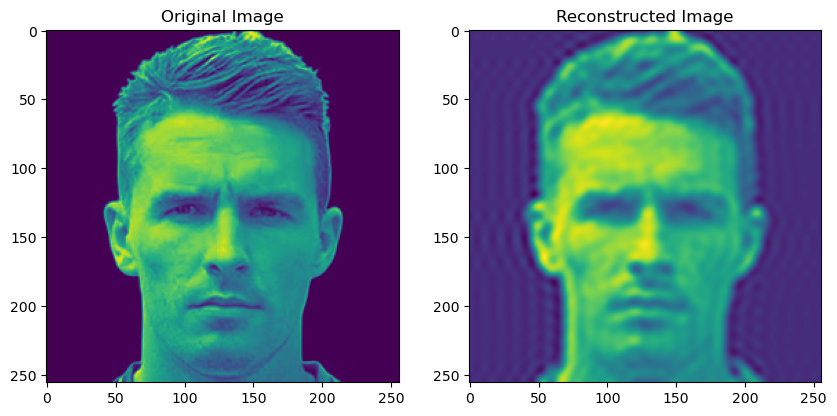

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title('Reconstructed Image')

plt.show()

In [12]:
normalized_result = image/255
normalized_original = X/255
difference = normalized_original - normalized_result
np.sum(abs(difference))

1964.4317441466487

In [13]:
print(mse(X, image))
print(mse(normalized_original,normalized_result ))
print(mad(X, image))

191.60353872174773
0.0029466134367050786
7.6435866509612325
